In [164]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, Sequence
from keras import backend as K 
from skimage.io import imread, imsave
from skimage.external.tifffile import TiffWriter
from scipy.ndimage import interpolation
from copy import deepcopy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
import time
import sys
import random
import cv2
import tensorflow as tf
from tensorflow import keras

In [165]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/data')
img_train_path = ('/content/gdrive/My Drive/data/2Dimages/train_img')
lesion_train_path = ('/content/gdrive/My Drive/data/2Dimages/train_lesion')
img_valid_path = ('/content/gdrive/My Drive/data/2Dimages/valid_img')
lesion_valid_path = ('/content/gdrive/My Drive/data/2Dimages/valid_lesion')
img_test_path = ('/content/gdrive/My Drive/data/2Dimages/test_img')
lesion_test_path = ('/content/gdrive/My Drive/data/2Dimages/test_lesion')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [166]:
seed = 2021
img_size = (128, 64)
data_args = dict(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

img_train_final = ImageDataGenerator(**data_args)
lesion_train_final = ImageDataGenerator(**data_args)
img_valid_final = ImageDataGenerator(rescale=1./255) 
lesion_valid_final = ImageDataGenerator(rescale=1./255)
img_test_final = ImageDataGenerator(rescale=1./255)
lesion_test_final = ImageDataGenerator(rescale=1./255)

flow_args = dict(target_size=img_size,
                 color_mode = 'grayscale',
                 batch_size = 32,
                 class_mode = None,
                 seed = seed)

img_train_generator = img_train_final.flow_from_directory(img_train_path, **flow_args)
lesion_train_generator = lesion_train_final.flow_from_directory(lesion_train_path, **flow_args)
train_generator = zip(img_train_generator, lesion_train_generator)
###############################################################################################
img_valid_generator = img_valid_final.flow_from_directory(img_valid_path, **flow_args)
lesion_valid_generator = lesion_valid_final.flow_from_directory(lesion_valid_path, **flow_args)
valid_generator = zip(img_valid_generator, lesion_valid_generator)
###############################################################################################
img_test_generator = img_test_final.flow_from_directory(img_test_path, **flow_args)
lesion_test_generator = lesion_test_final.flow_from_directory(lesion_test_path, **flow_args)
test_generator = zip(img_test_generator, lesion_test_generator)


x = img_train_generator.__getitem__(0)
print(x.shape)
y = lesion_train_generator.__getitem__(0)
print(y.shape)
x1 = img_valid_generator.__getitem__(0)
print(x1.shape)
y1 = lesion_valid_generator.__getitem__(0)
print(y1.shape)
x2 = img_test_generator.__getitem__(0)
print(x2.shape)
y2 = lesion_test_generator.__getitem__(0)
print(y2.shape)

Found 35 images belonging to 1 classes.
Found 35 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 79 images belonging to 1 classes.
Found 79 images belonging to 1 classes.
(32, 128, 64, 1)
(32, 128, 64, 1)
(32, 128, 64, 1)
(32, 128, 64, 1)
(32, 128, 64, 1)
(32, 128, 64, 1)


In [207]:
smooth = 1.

def dice(y_true, y_pred): # for numpy arrays
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = np.sum(y_true_f*y_pred_f)
    if np.sum(y_true_f + y_pred_f)==0:
        return 1.0
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    if K.sum(y_true_f + y_pred_f)==0:
        return 1.0
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [223]:
def check_masks(data_batch,labels_batch,predictions=None):
  if predictions is None:
    predictions = np.zeros_like(labels_batch)
  plt.figure(figsize=(8,8))
  
  for i, (img, mask, pred) in enumerate(zip(data_batch, labels_batch, predictions)):
        # image only
        plt.subplot(3,3,i+1)
        h = plt.imshow(np.squeeze(img), aspect='auto')
        h.set_cmap('gray')
        plt.axis('off') 
        plt.title('image %d'% (i+1))

        # overlay mask + image
        plt.subplot(3,3,i+4)
        merged = 0.7*np.tile(img, (1,1,3))
        if pred.max()==0:
            merged[:,:,1] += 0.7*np.squeeze(mask)
        else:
            merged[:,:,0] += 0.7*np.squeeze(pred)    
        merged[merged>1] = 1

        h = plt.imshow(merged, aspect='auto')
        plt.axis('off')
        if pred.max()==0:
            plt.title('mask with image %d'% (i+1))
        else:
            plt.title('Predictions')           
        
            
        # overlay mask + prediction
        plt.subplot(3,3,i+7)
        masks = np.concatenate([pred, np.zeros(mask.shape[:2]+(2,))], axis=2)
        masks[:,:,1] += np.squeeze(mask)
        plt.imshow(masks, aspect='auto')
        plt.axis('off')
        if pred.max()>0:
          plt.title('Dice: %1.3f' % dice_coef(mask, pred))
        else: 
          plt.title('mask %d'% (i+1))

        if i==2:
            break 


data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


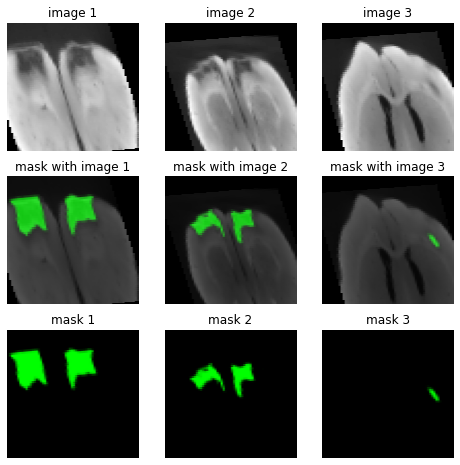

In [168]:
# check dataset
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

check_masks(data_batch, labels_batch)

In [169]:
one_weight = 0.95 # class weights
zero_weight = 0.05

def weighted_binary_crossentropy(y_true, y_pred):

    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

In [170]:
def batch_norm(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batch_norm(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def Mainbody(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = batch_norm(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=(3, 3), padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=(3, 3), padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def concat_blocks(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [171]:
def ResUNet(loss_fn=dice_coef_loss, lr=1e-3, act='relu', init='he_normal', pad='same', dropout=False):
    inputs = keras.layers.Input((128, 64, 1))
    
    ## Encoder
    c0 = inputs
    c1 = Mainbody(c0, 16)
    c2 = residual_block(c1, 32, strides=2)
    c3 = residual_block(c2, 64, strides=2)
    c4 = residual_block(c3, 128, strides=2)
    c5 = residual_block(c4, 256, strides=2)
    
    ## Bridge
    b0 = conv_block(c5, 256, strides=1)
    b1 = conv_block(b0, 256, strides=1)
    
    ## Decoder
    u1 = concat_blocks(b1, c4)
    d1 = residual_block(u1, 256)
    
    u2 = concat_blocks(d1, c3)
    d2 = residual_block(u2, 128)
    
    u3 = concat_blocks(d2, c2)
    d3 = residual_block(u3, 64)
    
    u4 = concat_blocks(d3, c1)
    d4 = residual_block(u4, 32)
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [173]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 128, 64, 16)  160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 128, 64, 16)  64          conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 64, 16)  0           batch_normalization_56[0][0]     
____________________________________________________________________________________________

In [174]:
checkpoint = ModelCheckpoint(filepath='ResUNet.h5', monitor='val_loss', save_best_only=True)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=10,
    verbose=1,
    callbacks=[checkpoint])



Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 136s 5s/step - loss: 0.6256 - dice_coef: 0.3609 - val_loss: 0.8872 - val_dice_coef: 0.1105
Epoch 2/20
30/30 [==============================] - 132s 5s/step - loss: 0.2064 - dice_coef: 0.7652 - val_loss: 1.0000 - val_dice_coef: 2.2044e-05
Epoch 3/20
30/30 [==============================] - 132s 5s/step - loss: 0.1877 - dice_coef: 0.7833 - val_loss: 0.9213 - val_dice_coef: 0.0773
Epoch 4/20
30/30 [==============================] - 132s 5s/step - loss: 0.1794 - dice_coef: 0.7681 - val_loss: 0.8538 - val_dice_coef: 0.1402
Epoch 5/20
30/30 [==============================] - 132s 5s/step - loss: 0.1841 - dice_coef: 0.7855 - val_loss: 0.9108 - val_dice_coef: 0.0902
Epoch 6/20
30/30 [==============================] - 132s 5s/step - loss: 0.2225 - dice_coef: 0.6815 - val_loss: 0.8557 - val_dice_coef: 0.1412
Epoch 7/20
30/30 [==============================] - 132s 5s/step - loss: 0.1553 - dice_coef: 0.8226 - val_loss: 0.9467 - val_dice_coef: 0.0525
Epoch 

In [175]:
def plot_performance(history):
    dicec = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(dicec))
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(epochs, dicec, label='Training dice')
    plt.plot(epochs, val_dice, label='Validation dice')
    plt.xlabel("Num of Epochs")
    plt.ylabel("dice")
    plt.title('Training and validation dice')
    plt.legend()

    plt.subplot(1,2,2)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

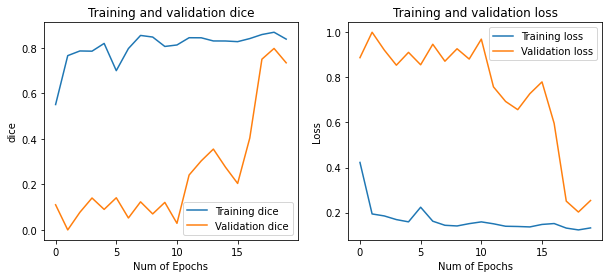

In [176]:
plot_performance(history)

In [177]:
# load best model
model.load_weights('ResUnet.h5')

data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


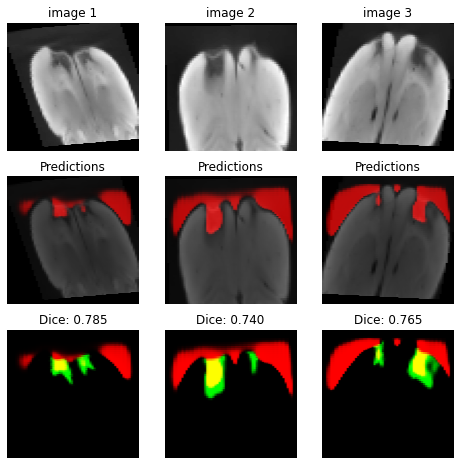

In [214]:
# training set performance
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
check_masks(data_batch, labels_batch, predict_batch)

data batch shape: (32, 128, 64, 1)
labels batch shape: (32, 128, 64, 1)


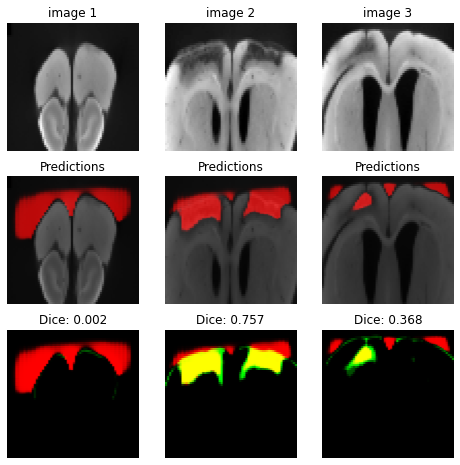

In [225]:
# validation set performance
for data_batch, labels_batch in valid_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
check_masks(data_batch, labels_batch, predict_batch)

data batch shape: (15, 128, 64, 1)
labels batch shape: (15, 128, 64, 1)


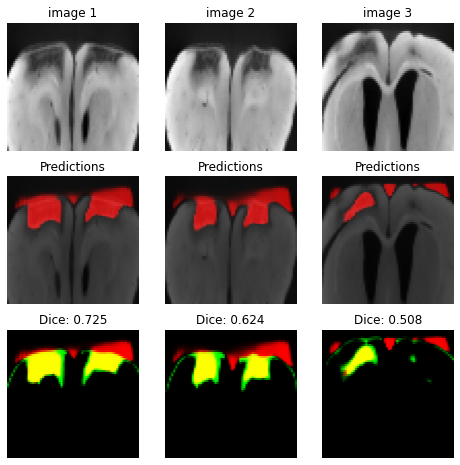

In [226]:
# test set performance
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

predict_batch = model.predict_on_batch(data_batch)
    
check_masks(data_batch, labels_batch, predict_batch)